# [**Air Quality and Pollution Assessment**](https://www.kaggle.com/datasets/prasad22/healthcare-dataset)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Create a directory for the dataset
!mkdir -p /content/Air_Quality_Pollution

# Use Kaggle API to download the dataset directly
!curl -L -o /content/Air_Quality_Pollution/air-quality-and-pollution-assessment.zip \
  https://www.kaggle.com/api/v1/datasets/download/mujtabamatin/air-quality-and-pollution-assessment

# Unzip the dataset into a target folder
!unzip -q /content/Air_Quality_Pollution/air-quality-and-pollution-assessment.zip -d /content/data


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 86068  100 86068    0     0  99434      0 --:--:-- --:--:-- --:--:-- 99434


In [4]:
!ls /content/data

updated_pollution_dataset.csv


In [5]:
import pandas as pd

# Path to your CSV file
file_path = '/content/data/updated_pollution_dataset.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())
print(df.columns)


   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good  
Index(['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO',
       'Proximity_to_Industrial_Areas', 'Population_Density', 'Air Quality'],
      dtype='object')


**Check for Missing Values**

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64


In [7]:
# Function to detect outliers using the IQR method
def has_outliers(df):
    for col in df.select_dtypes(include=['float64', 'int64']):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        if ((df[col] < lower_bound) | (df[col] > upper_bound)).any():
            return True
    return False

# Check for outliers
outliers_present = has_outliers(df)
print(f"Outliers: {'Yes' if outliers_present else 'No'}")

Outliers: Yes


In [8]:
# Function to cap outliers
def cap_outliers(df):
    for col in df.select_dtypes(include=['float64', 'int64']):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Cap outliers in the dataset
df = cap_outliers(df)


In [9]:
# Check for outliers
outliers_present = has_outliers(df)
print(f"Outliers: {'Yes' if outliers_present else 'No'}")

Outliers: No


In [10]:


# Check the class distribution for 'Air Quality'
class_counts = df['Air Quality'].value_counts()
print("Class Distribution:\n", class_counts)

# Check if the dataset is balanced
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

# If the ratio is greater than 1.5, it indicates imbalance
if imbalance_ratio > 1.5:
    print("Imbalanced Data: Yes")
else:
    print("Imbalanced Data: No")


Class Distribution:
 Air Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64
Imbalance Ratio: 4.00
Imbalanced Data: Yes


In [11]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop(columns=['Air Quality'])
y = df['Air Quality']

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
new_class_distribution = pd.Series(y_resampled).value_counts()
print("New Class Distribution:\n", new_class_distribution)

New Class Distribution:
 Air Quality
Moderate     2000
Good         2000
Hazardous    2000
Poor         2000
Name: count, dtype: int64


In [57]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Standardize the features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Apply PCA
pca = PCA(n_components=2)  # Change n_components as needed
X_pca = pca.fit_transform(X_resampled_scaled)

# Check the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:\n", explained_variance)

# Convert PCA result to a DataFrame for analysis
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components)])
X_pca_df['Air Quality'] = y_resampled
print(X_pca_df.head())


Explained Variance Ratio:
 [0.5865408  0.14452506]
        PC1       PC2 Air Quality
0 -1.815677 -0.396868    Moderate
1 -0.674112 -1.245671    Moderate
2 -0.318154  0.366529    Moderate
3 -3.274769 -0.109875        Good
4 -2.963772  0.105012        Good


# Visualize the PCA Components

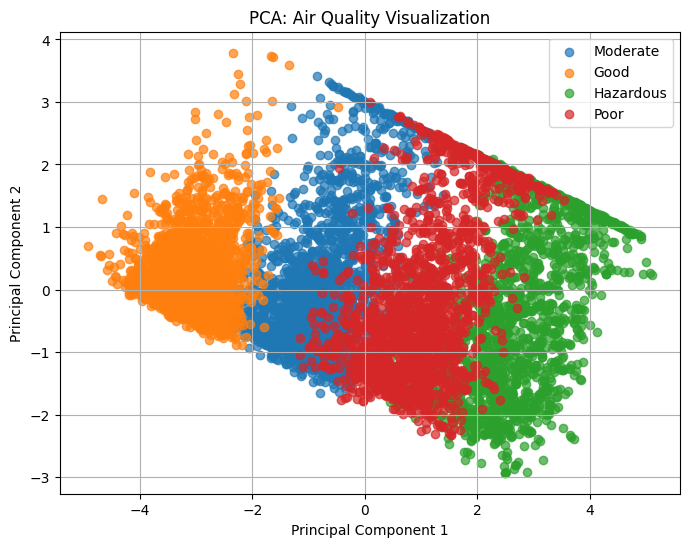

In [58]:
import matplotlib.pyplot as plt

# Scatter plot of the PCA-transformed data
plt.figure(figsize=(8, 6))
for air_quality in X_pca_df['Air Quality'].unique():
    subset = X_pca_df[X_pca_df['Air Quality'] == air_quality]
    plt.scatter(subset['PC1'], subset['PC2'], label=air_quality, alpha=0.7)

plt.title('PCA: Air Quality Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

# SVC with Linear Kernel

Classification Report:
               precision    recall  f1-score   support

        Good       0.97      0.99      0.98       418
   Hazardous       0.90      0.87      0.88       385
    Moderate       0.92      0.90      0.91       417
        Poor       0.79      0.82      0.81       380

    accuracy                           0.90      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.90      0.90      0.90      1600


Confusion Matrix:
 [[415   0   3   0]
 [  0 334   0  51]
 [ 12   0 375  30]
 [  0  37  30 313]]


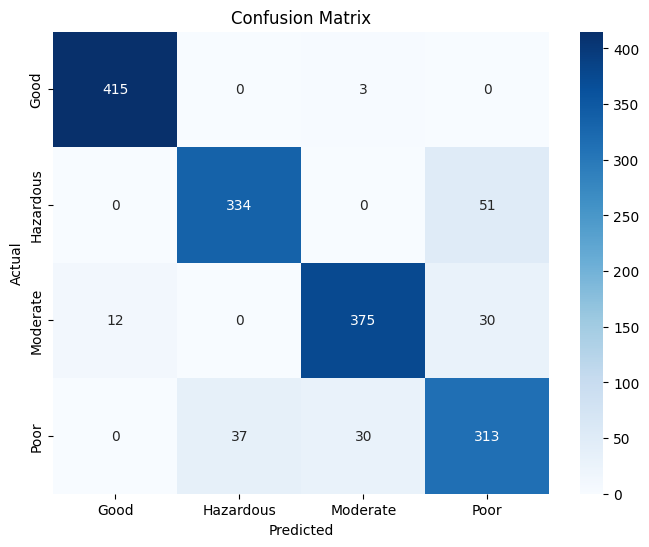

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_df[['PC1', 'PC2']],
                                                    X_pca_df['Air Quality'],
                                                    test_size=0.2,
                                                    random_state=42)

# Train an SVM classifier with a linear kernel
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svc.classes_, yticklabels=svc.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

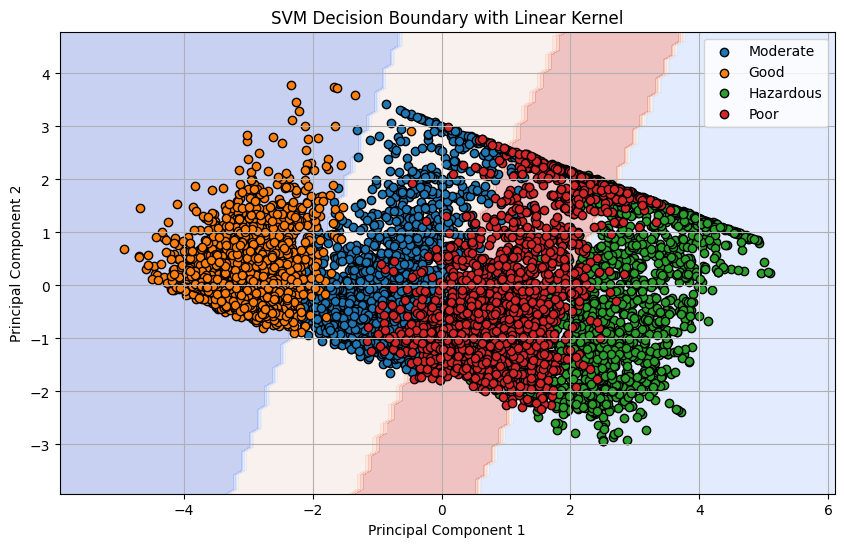

In [62]:
import numpy as np

# Create a mesh grid for the decision boundary
x_min, x_max = X_train['PC1'].min() - 1, X_train['PC1'].max() + 1
y_min, y_max = X_train['PC2'].min() - 1, X_train['PC2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict the labels for each point in the mesh grid
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Map class labels to numeric values
class_mapping = {label: idx for idx, label in enumerate(svc.classes_)}
numeric_predictions = np.vectorize(class_mapping.get)(Z)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, numeric_predictions, alpha=0.3, cmap='coolwarm')
for air_quality in X_pca_df['Air Quality'].unique():
    subset = X_pca_df[X_pca_df['Air Quality'] == air_quality]
    plt.scatter(subset['PC1'], subset['PC2'], label=air_quality, edgecolor='k')
plt.title('SVM Decision Boundary with Linear Kernel')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()


# **Bayesian Optimization**

In [63]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.7 MB/s eta 0:00:00


In [64]:
from skopt import BayesSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_df[['PC1', 'PC2']],
                                                    X_pca_df['Air Quality'],
                                                    test_size=0.2,
                                                    random_state=42)

# Define the parameter space for the Bayesian optimization
param_space = {
    'C': (0.1, 10.0, 'uniform'),  # Regularization parameter
    'gamma': (0.001, 1.0, 'uniform'),  # Kernel coefficient
    'kernel': ['linear', 'rbf']  # Kernel type
}

# Initialize the Bayesian optimizer
bayes_search = BayesSearchCV(SVC(), param_space, n_iter=50, cv=5, n_jobs=-1, random_state=42)

# Fit the model
bayes_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found: ", bayes_search.best_params_)

# Make predictions with the best model
y_pred = bayes_search.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

Best parameters found:  OrderedDict([('C', 3.676136666696511), ('gamma', 0.044836473821446024), ('kernel', 'rbf')])
Classification Report:
               precision    recall  f1-score   support

        Good       0.97      0.99      0.98       418
   Hazardous       0.91      0.85      0.88       385
    Moderate       0.92      0.91      0.91       417
        Poor       0.79      0.83      0.81       380

    accuracy                           0.90      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.90      0.90      0.90      1600



In [65]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [66]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

base_learners = [
    ('svm', SVC(kernel='linear')),
    ('rf', RandomForestClassifier(n_estimators=100)),
]
model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        Good       0.97      1.00      0.98       418
   Hazardous       0.90      0.90      0.90       385
    Moderate       0.92      0.91      0.92       417
        Poor       0.82      0.82      0.82       380

    accuracy                           0.91      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.91      0.91      0.91      1600



In [69]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
model.fit(X_resampled, y_resampled)

StackingClassifier(estimators=[('svm', SVC(kernel='linear')),
                               ('rf', RandomForestClassifier())],
                   final_estimator=LogisticRegression())

In [70]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.97      1.00      0.98       418
   Hazardous       0.90      0.90      0.90       385
    Moderate       0.92      0.91      0.91       417
        Poor       0.83      0.81      0.82       380

    accuracy                           0.91      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.90      0.91      0.91      1600



In [74]:
from sklearn.model_selection import GridSearchCV

# SVC Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.01, 0.1]}
grid_search_svc = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train, y_train)

# RandomForest Hyperparameter tuning
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [75]:
best_svc = grid_search_svc.best_estimator_
best_rf = grid_search_rf.best_estimator_

base_learners = [
    ('svm', best_svc),
    ('rf', best_rf),
]
model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
model.fit(X_train, y_train)


StackingClassifier(estimators=[('svm', SVC(C=10, gamma=0.01)),
                               ('rf', RandomForestClassifier(max_depth=10))],
                   final_estimator=LogisticRegression())

In [76]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.98      1.00      0.99       418
   Hazardous       0.91      0.87      0.89       385
    Moderate       0.92      0.92      0.92       417
        Poor       0.81      0.83      0.82       380

    accuracy                           0.91      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.91      0.91      0.91      1600



In [77]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

model.fit(X_pca, y_train)


StackingClassifier(estimators=[('svm', SVC(C=10, gamma=0.01)),
                               ('rf', RandomForestClassifier(max_depth=10))],
                   final_estimator=LogisticRegression())

In [78]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.98      0.99      0.98       418
   Hazardous       0.91      0.88      0.90       385
    Moderate       0.92      0.92      0.92       417
        Poor       0.82      0.84      0.83       380

    accuracy                           0.91      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.91      0.91      0.91      1600



In [80]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [81]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=200)
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
print(classification_report(y_test, y_pred))


0:	learn: 1.1872133	total: 58.2ms	remaining: 58.2s
200:	learn: 0.2175679	total: 2.77s	remaining: 11s
400:	learn: 0.1976675	total: 5.33s	remaining: 7.97s
600:	learn: 0.1833194	total: 8.16s	remaining: 5.42s
800:	learn: 0.1726707	total: 11.3s	remaining: 2.81s
999:	learn: 0.1636171	total: 15.6s	remaining: 0us
              precision    recall  f1-score   support

        Good       0.97      0.99      0.98       418
   Hazardous       0.93      0.87      0.90       385
    Moderate       0.92      0.91      0.91       417
        Poor       0.81      0.85      0.83       380

    accuracy                           0.91      1600
   macro avg       0.91      0.90      0.91      1600
weighted avg       0.91      0.91      0.91      1600



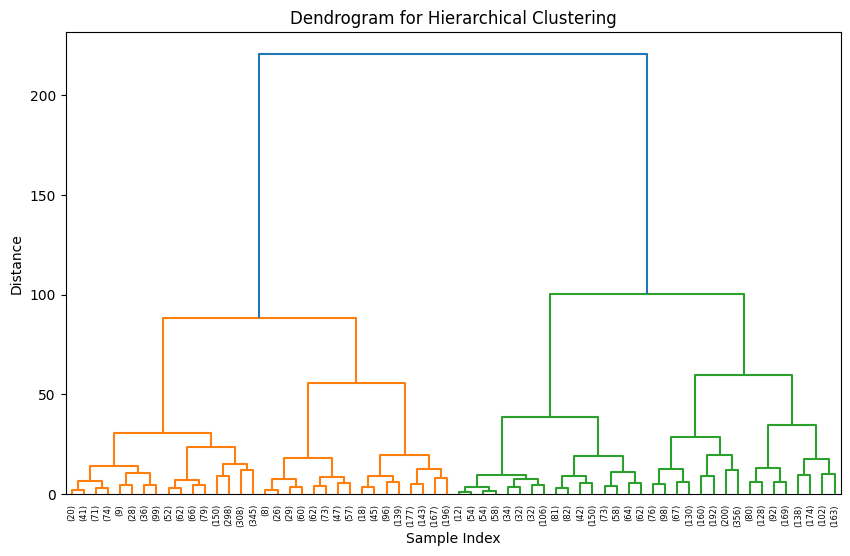

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming X_train is your dataset
Z = linkage(X_train, method='ward')

# Create the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=5)  # You can adjust 'p' for more or fewer levels
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


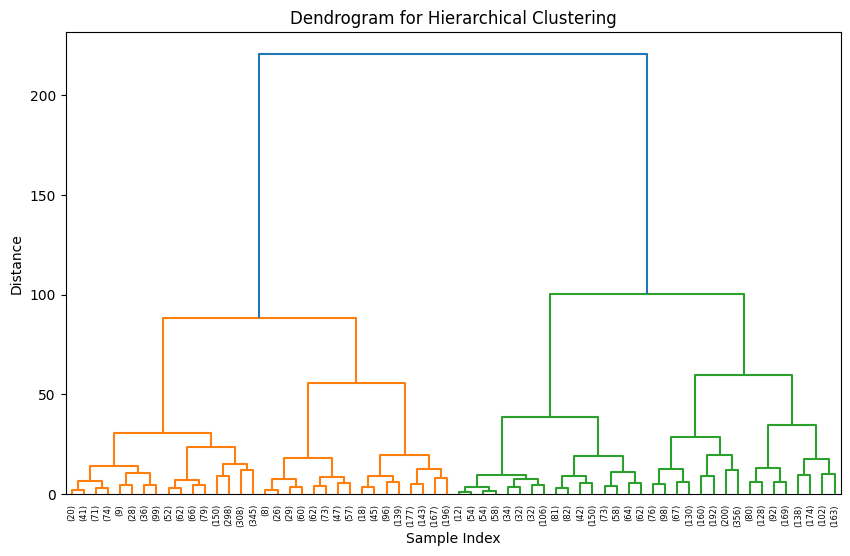

The optimal number of clusters (k) based on the threshold 10 is: 26


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Assuming X_train is your data (replace with your actual data)
# X_train = your_dataframe_or_numpy_array

# Perform hierarchical clustering
Z = linkage(X_train, method='ward')

# Create a dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Set a threshold distance to cut the dendrogram and find k
# You can adjust the 'threshold' value to control how many clusters you want
threshold = 10  # This can be adjusted to change the number of clusters
clusters = fcluster(Z, threshold, criterion='distance')

# The number of clusters is the maximum label in the clusters array
k = len(np.unique(clusters))

print(f"The optimal number of clusters (k) based on the threshold {threshold} is: {k}")


In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

base_learners = [
    ('svm', SVC(kernel='linear')),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('knn', KNeighborsClassifier(n_neighbors=26))
]

model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
model.fit(X_train, y_train)


StackingClassifier(estimators=[('svm', SVC(kernel='linear')),
                               ('rf', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier(n_neighbors=26))],
                   final_estimator=LogisticRegression())

In [88]:
y_pred = catboost_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.97      0.99      0.98       418
   Hazardous       0.93      0.87      0.90       385
    Moderate       0.92      0.91      0.91       417
        Poor       0.81      0.85      0.83       380

    accuracy                           0.91      1600
   macro avg       0.91      0.90      0.91      1600
weighted avg       0.91      0.91      0.91      1600

